In [106]:
import networkx as nx
import dill as pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import scipy.optimize as opt
import copy
from mpl_toolkits.basemap import Basemap
import collections
import pandas as pd
# Supress warnings
import warnings
warnings.filterwarnings("ignore")

In [107]:
# Read pickled graphs graph_objects/G_multi_directed.pickle, graph_objects/G_multi_undirected.pickle, graph_objects/G_simple_directed.pickle, graph_objects/G_simple_undirected.pickle
with open('graph_objects/G_multi_directed_iggielgn.pickle', 'rb') as f:
    G_multi_directed = pickle.load(f)

with open('graph_objects/G_multi_undirected_iggielgn.pickle', 'rb') as f:
    G_multi_undirected = pickle.load(f)

with open('graph_objects/G_simple_directed_iggielgn.pickle', 'rb') as f:
    G_simple_directed = pickle.load(f)

with open('graph_objects/G_simple_undirected_iggielgn.pickle', 'rb') as f:
    G_simple_undirected = pickle.load(f)

In [108]:
# Create a dictionary. The keys are the country_codes and the values are 1) the number of nodes in the country 2) the number of to_edges in the country 3) the number of from_edges in the country 4) the number of total edges in the country

country_dict = {}
for node in G_multi_directed.nodes:
    country_code = G_multi_directed.nodes[node]['country_code']
    if country_code in country_dict:
        country_dict[country_code][0] += 1
    else:
        country_dict[country_code] = [1, 0, 0]

for edge in G_multi_directed.edges(data=True):
    from_country_code = edge[2]['from_country_code']
    to_country_code = edge[2]['to_country_code']
    if from_country_code in country_dict:
        country_dict[from_country_code][1] += 1
    else:
        country_dict[from_country_code] = [0, 1, 0]
    if to_country_code in country_dict:
        country_dict[to_country_code][2] += 1

In [109]:
countries_df = pd.DataFrame.from_dict(country_dict, orient='index', columns=['number_of_nodes', 'number_of_to_edges', 'number_of_from_edges'])
countries_df.head()
countries_list = countries_df.index.tolist()

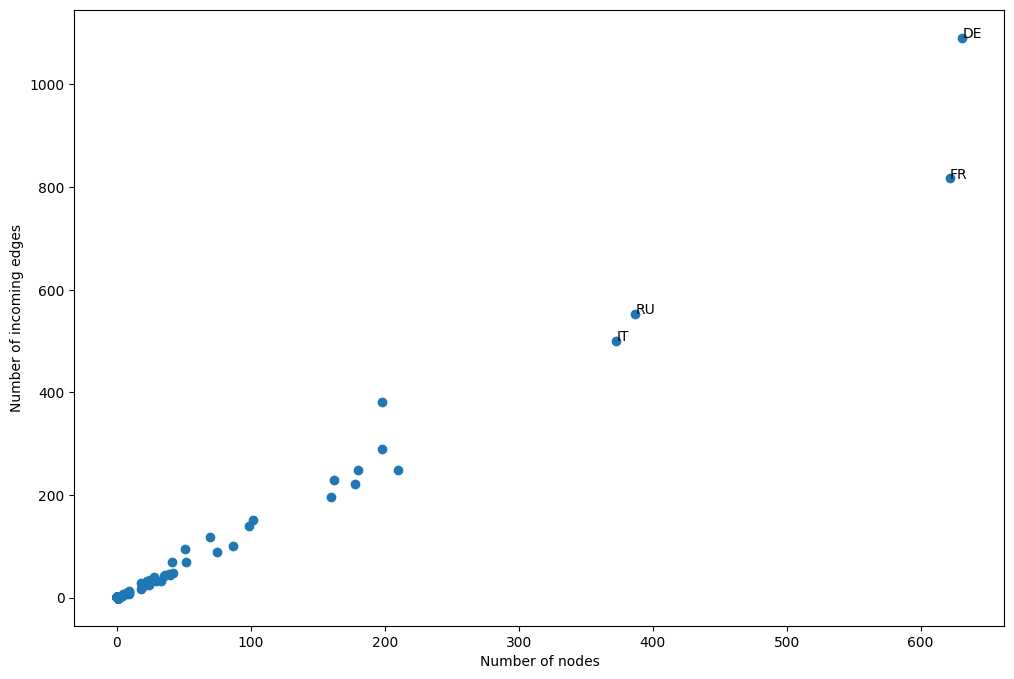

In [110]:
# Using the number_nodes as the x-axis and the number_of_to_edges as the y-axis, plot the number of to_edges vs the number of nodes
plt.figure(figsize=(12, 8))
plt.scatter(countries_df['number_of_nodes'], countries_df['number_of_to_edges'])
plt.xlabel('Number of nodes')
plt.ylabel('Number of incoming edges')
for i, txt in enumerate(countries_df.index):
    if countries_df['number_of_nodes'][i] > 300:
        plt.annotate(txt, (countries_df['number_of_nodes'][i], countries_df['number_of_to_edges'][i]))

plt.savefig('latex_figures/number_of_nodes_vs_number_of_to_edges.png')
plt.show()

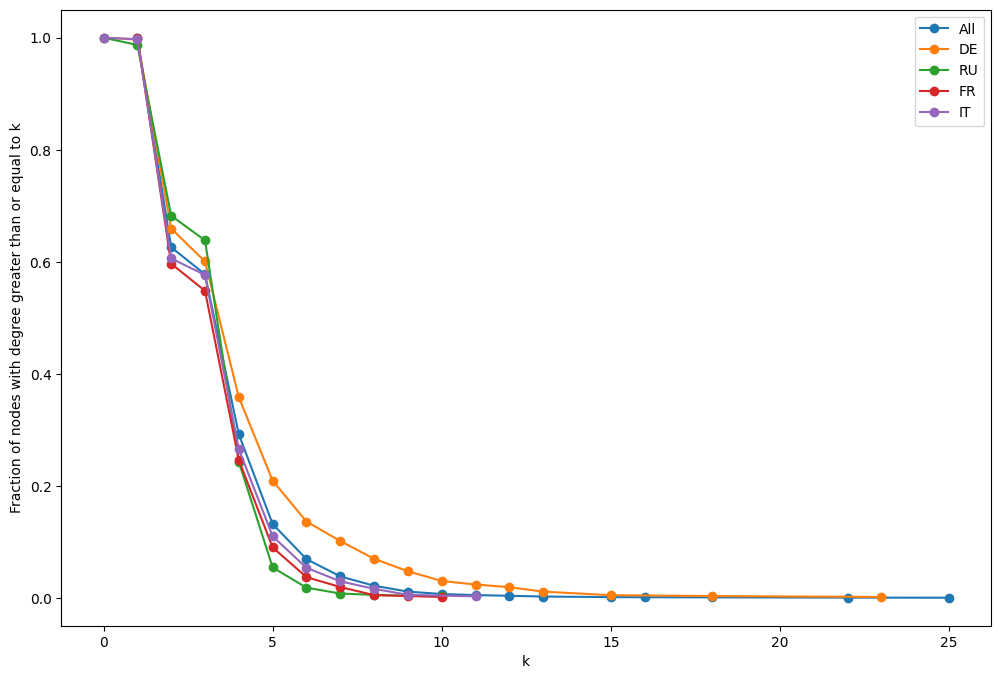

In [111]:
# Do the same as above, but do five different series, one for the entire graph, one for nodes where country_code is DE, RU, FR, and IT
plt.figure(figsize=(12, 8))
# Keep in min I want to plot the fraction of nodes with degree greater than or equal to k vs k
# One would expect the curve to begin at 1 and decrease to 0
degree_sequence = sorted([d for n, d in G_multi_directed.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cumulative_cnt = np.cumsum(cnt)
cumulative_cnt = cumulative_cnt / cumulative_cnt[-1]
plt.plot(deg, cumulative_cnt, 'o-', label='All')

for country_code in ['DE', 'RU', 'FR', 'IT']:
    # Create a subgraph of G_multi_directed where the country_code is the one we are interested in
    sub_graph = G_multi_directed.subgraph([n for n in G_multi_directed.nodes if G_multi_directed.nodes[n]['country_code'] == country_code])
    degree_sequence = sorted([d for n, d in sub_graph.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    cumulative_cnt = np.cumsum(cnt)
    cumulative_cnt = cumulative_cnt / cumulative_cnt[-1]
    plt.plot(deg, cumulative_cnt, 'o-', label=country_code)

plt.xlabel('k')
plt.ylabel('Fraction of nodes with degree greater than or equal to k')
plt.legend()

plt.savefig('latex_figures/degree_distribution_selected.png')
plt.show()

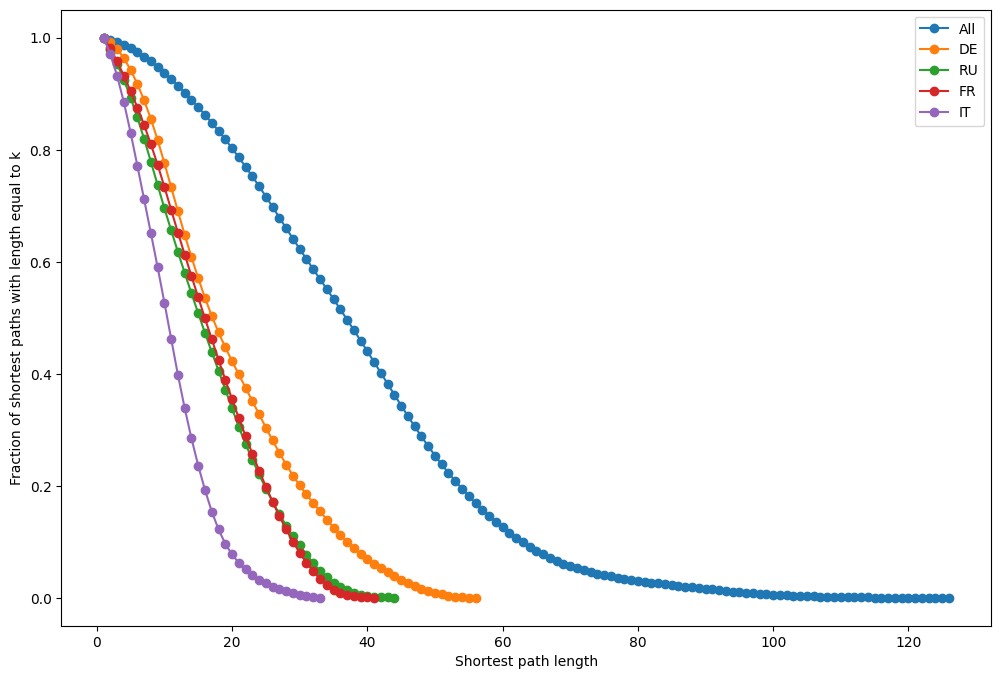

In [112]:
# Do the same as above, only do the shortest path length distribution
plt.figure(figsize=(12, 8))
shortest_path_lengths = nx.shortest_path_length(G_multi_directed)
shortest_path_lengths = [length for node, lengths in shortest_path_lengths for length in lengths.values()]
shortest_path_lengths = [length for length in shortest_path_lengths if length != 0]
shortest_path_lengths = sorted(shortest_path_lengths, reverse=True)
shortest_path_lengths_count = collections.Counter(shortest_path_lengths)
spl, cnt = zip(*shortest_path_lengths_count.items())
cumulative_cnt = np.cumsum(cnt)
cumulative_cnt = cumulative_cnt / cumulative_cnt[-1]
plt.plot(spl, cumulative_cnt, 'o-', label='All')

for country_code in ['DE', 'RU', 'FR', 'IT']:
    # Create a subgraph of G_multi_directed where the country_code is the one we are interested in
    sub_graph = G_multi_directed.subgraph([n for n in G_multi_directed.nodes if G_multi_directed.nodes[n]['country_code'] == country_code])
    shortest_path_lengths = nx.shortest_path_length(sub_graph)
    shortest_path_lengths = [length for node, lengths in shortest_path_lengths for length in lengths.values()]
    shortest_path_lengths = [length for length in shortest_path_lengths if length != 0]
    shortest_path_lengths = sorted(shortest_path_lengths, reverse=True)
    shortest_path_lengths_count = collections.Counter(shortest_path_lengths)
    spl, cnt = zip(*shortest_path_lengths_count.items())
    cumulative_cnt = np.cumsum(cnt)
    cumulative_cnt = cumulative_cnt / cumulative_cnt[-1]
    plt.plot(spl, cumulative_cnt, 'o-', label=country_code)
    
plt.xlabel('Shortest path length')
plt.ylabel('Fraction of shortest paths with length equal to k')
plt.legend()

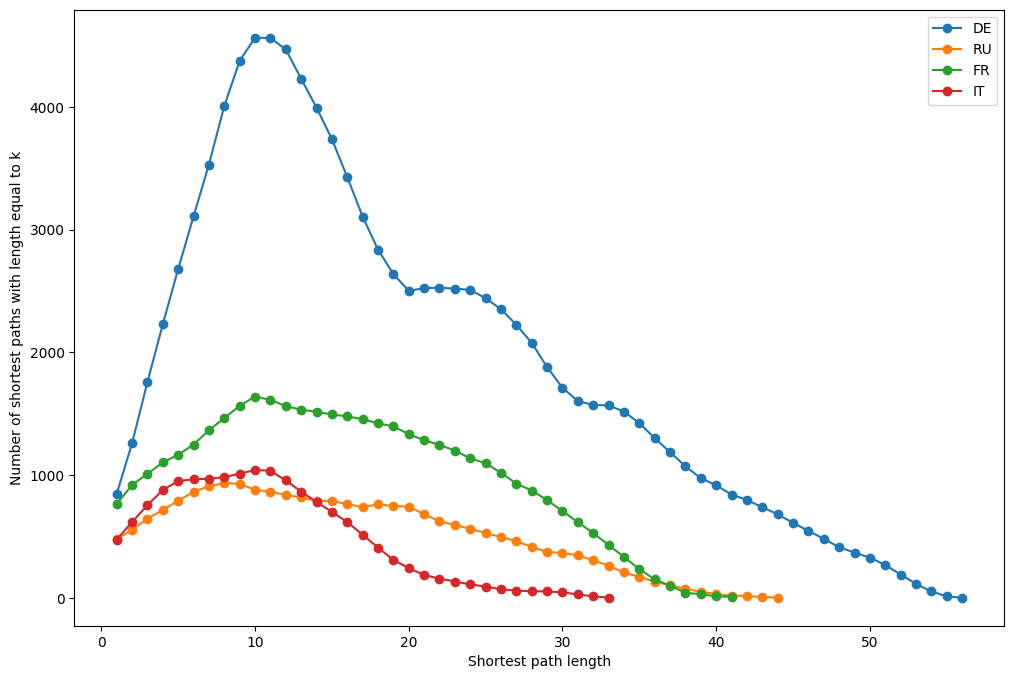

In [113]:
# Plot the normal shortest path length distribution (i.e., not cumulative)
plt.figure(figsize=(12, 8))

for country_code in ['DE', 'RU', 'FR', 'IT']:
    # Create a subgraph of G_multi_directed where the country_code is the one we are interested in
    sub_graph = G_multi_directed.subgraph([n for n in G_multi_directed.nodes if G_multi_directed.nodes[n]['country_code'] == country_code])
    shortest_path_lengths = nx.shortest_path_length(sub_graph)
    shortest_path_lengths = [length for node, lengths in shortest_path_lengths for length in lengths.values()]
    shortest_path_lengths = [length for length in shortest_path_lengths if length != 0]
    shortest_path_lengths = sorted(shortest_path_lengths, reverse=True)
    shortest_path_lengths_count = collections.Counter(shortest_path_lengths)
    spl, cnt = zip(*shortest_path_lengths_count.items())
    plt.plot(spl, cnt, 'o-', label=country_code)

plt.xlabel('Shortest path length')
plt.ylabel('Number of shortest paths with length equal to k')
plt.legend()

plt.savefig('latex_figures/shortest_path_length_distribution_selected.png')
plt.show()

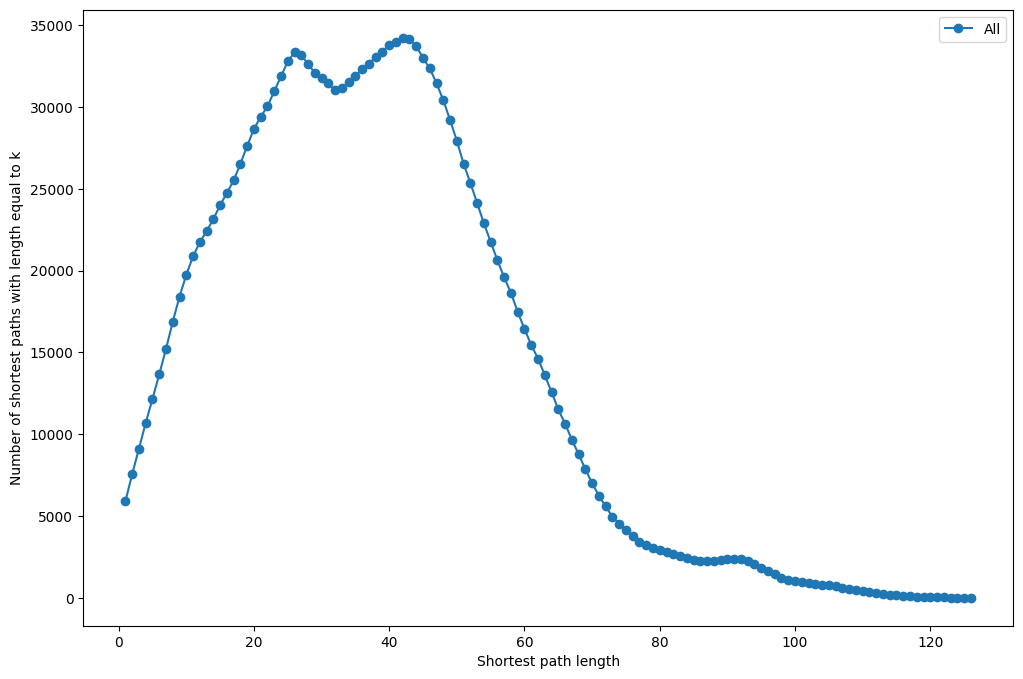

In [114]:
# Do the same for the entire graph
plt.figure(figsize=(12, 8))
shortest_path_lengths = nx.shortest_path_length(G_multi_directed)
shortest_path_lengths = [length for node, lengths in shortest_path_lengths for length in lengths.values()]
shortest_path_lengths = [length for length in shortest_path_lengths if length != 0]
shortest_path_lengths = sorted(shortest_path_lengths, reverse=True)
shortest_path_lengths_count = collections.Counter(shortest_path_lengths)
spl, cnt = zip(*shortest_path_lengths_count.items())
plt.plot(spl, cnt, 'o-', label='All')

plt.xlabel('Shortest path length')
plt.ylabel('Number of shortest paths with length equal to k')
plt.legend()

plt.savefig('latex_figures/shortest_path_length_distribution_all.png')
plt.show()

In [115]:
# Write a function that takes in a graph, and returns the number of nodes, edges, inflection points, and bridges in the graph
def get_bridges_and_articulation(graph, country_code=None):
    if country_code:
        graph = graph.subgraph([n for n in graph.nodes if graph.nodes[n]['country_code'] == country_code])
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    num_articulation_points = len(list(nx.articulation_points(graph)))
    num_bridges = len(list(nx.bridges(graph)))
    return num_nodes, num_edges, num_articulation_points, num_bridges

In [116]:
# Test the function on G_multi_directed
print(get_bridges_and_articulation(G_multi_undirected))

(4675, 6160, 1706, 2210)


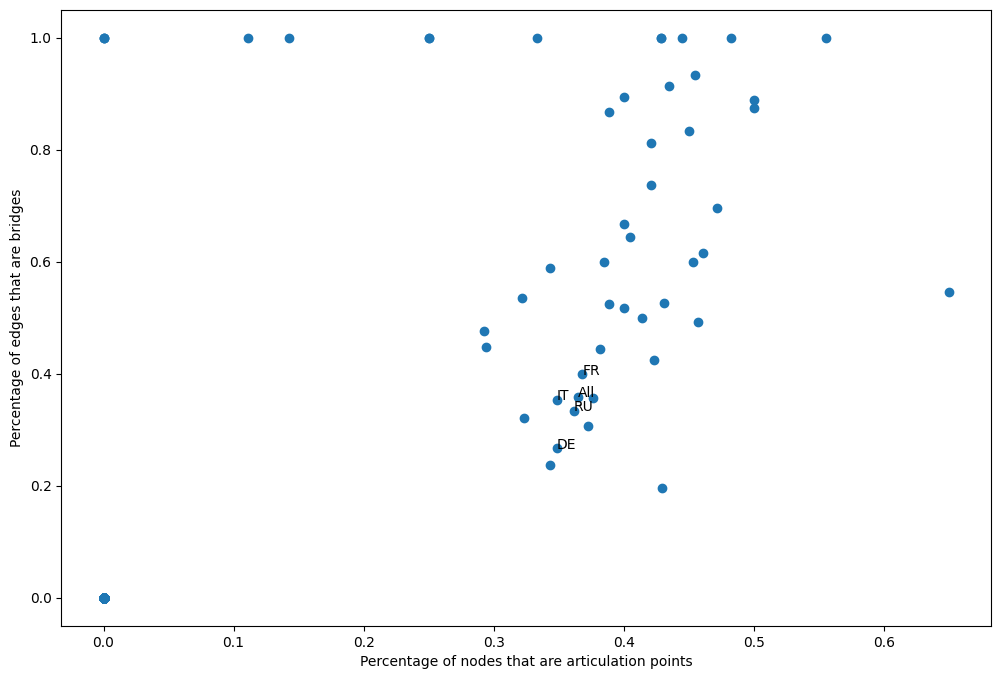

In [117]:
# Plot the percentage of nodes that are articulation points and bridges for all countries and the entire graph
articulation_share = []
bridges_share = []
for country_code in countries_list:
    num_nodes, num_edges, num_articulation_points, num_bridges = get_bridges_and_articulation(G_multi_undirected, country_code)
    try:
        articulation_share.append(num_articulation_points / num_nodes)
    except ZeroDivisionError:
        articulation_share.append(0)
    try:
        bridges_share.append(num_bridges / num_edges)
    except ZeroDivisionError:
        bridges_share.append(0)

articulation_share.append(len(list(nx.articulation_points(G_multi_undirected))) / G_multi_undirected.number_of_nodes())
bridges_share.append(len(list(nx.bridges(G_multi_undirected))) / G_multi_undirected.number_of_edges())

plt.figure(figsize=(12, 8))
plt.scatter(articulation_share, bridges_share)
plt.xlabel('Percentage of nodes that are articulation points')
plt.ylabel('Percentage of edges that are bridges')
# Give labels to DE, RU, FR, IT
for i, txt in enumerate(countries_list):
    if countries_df['number_of_nodes'][i] > 300:
        plt.annotate(txt, (articulation_share[i], bridges_share[i]))
# Give label to the country with both shares = 0
plt.annotate('All', (articulation_share[-1], bridges_share[-1]))

plt.savefig('latex_figures/percentage_of_nodes_that_are_articulation_points_vs_percentage_of_edges_that_are_bridges.png')
plt.show()

In [102]:
countries_df

,number_of_nodes,number_of_to_edges,number_of_from_edges
PL,198,289,291
IT,373,500,500
AL,2,2,2
SK,18,28,23
GB,178,222,220
...,...,...,...
NaN,0,1,0
NaN,0,1,0
NaN,0,1,0
NaN,0,1,0
